In [106]:
import spacy
nlp = spacy.load('en')

In [111]:
nlp(u'hi')

hi

In [105]:

class Parse(object):
    def __init__(self, nlp, text, collapse_punctuation, collapse_phrases):
        self.doc = nlp(text)
        if collapse_punctuation:
            spans = []
            for word in self.doc[:-1]:
                if word.is_punct:
                    continue
                if not word.nbor(1).is_punct:
                    continue
                start = word.i
                end = word.i + 1
                while end < len(self.doc) and self.doc[end].is_punct:
                    end += 1
                span = self.doc[start : end]
                spans.append(
                    (span.start_char, span.end_char, word.tag_, word.lemma_, word.ent_type_)
                )
            for span_props in spans:
                self.doc.merge(*span_props)

        if collapse_phrases:
            for np in list(self.doc.noun_chunks):
                np.merge(np.root.tag_, np.root.lemma_, np.root.ent_type_)

    def to_json(self):
        words = [{'text': w.text, 'tag': w.tag_} for w in self.doc]
        arcs = []
        for word in self.doc:
            if word.i < word.head.i:
                arcs.append(
                    {
                        'start': word.i,
                        'end': word.head.i,
                        'label': word.dep_,
                        'dir': 'left'
                    })
            elif word.i > word.head.i:
                arcs.append(
                    {
                        'start': word.head.i,
                        'end': word.i,
                        'label': word.dep_,
                        'dir': 'right'
                    })
        return {'words': words, 'arcs': arcs}

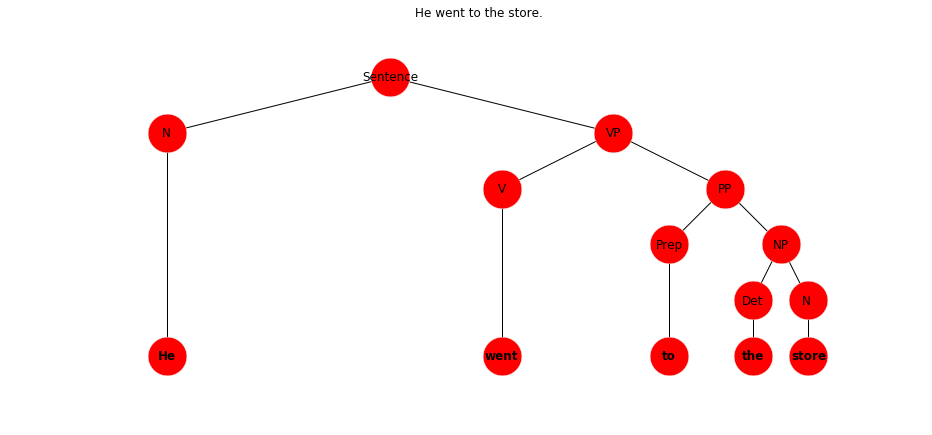

In [67]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 7)
from matplotlib import pyplot as plt
import networkx as nx
from IPython.display import SVG, HTML


ax = draw_consituency('He went to the store.')


In [95]:
HTML('dep_parse.html')

In [96]:
HTML(elephant_parse)

In [139]:
axioms = """

<center>
<h3> Axioms of Dependency Grammar: </h3>
<br>
<h4>1) Each sentence has exactly one root.</h4>
<br>
<object data="axiom1.svg" type="image/svg+xml">
  <img src="axiom1.jpg" />
</object>
<br>
<h4>2) Every word other than the root depends on another element.</h4>
<br>
<object data="singlehead.svg" type="image/svg+xml">
  <img src="singlehead.jpg" width = 50/>
</object>
<br>
<h4>3) No word can depend on more than one element.</h4>
<br>
<object data="non-multi-headed.svg" type="image/svg+xml">
  <img src="non-multi-headed.jpg" width = 50/>
</object>

<br>
<object data="non-multi-headed-normative.svg" type="image/svg+xml">
  <img src="non-multi-headed-normative.jpg" width = 50/>
</object>
<br>
<h4>4) Dependencies do not cross each other (planar trees).</h4>
<br>
<object data="planar-parse.svg" type="image/svg+xml">
  <img src="planar-parse.jpg" width = 50/>
</object>

<br>
<object data="non-planar-parse.svg" type="image/svg+xml">
  <img src="non-planar-parse.jpg" width = 50/>
</object>

</center>

"""

HTML(axioms)

In [42]:
def hierarchy_pos(G, root, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5, 
                  pos = None, parent = None):
    '''If there is a cycle that is reachable from root, then this will see infinite recursion.
       G: the graph
       root: the root node of current branch
       width: horizontal space allocated for this branch - avoids overlap with other branches
       vert_gap: gap between levels of hierarchy
       vert_loc: vertical location of root
       xcenter: horizontal location of root
       pos: a dict saying where all nodes go if they have been assigned
       parent: parent of this branch.'''
    

    
    if pos == None:
        pos = {root:(xcenter,vert_loc)}
    else:
        pos[root] = (xcenter, vert_loc)
        
    
    neighbors = G.neighbors(root)
    if parent != None:
        if parent in neighbors:
            neighbors.remove(parent)
    if len(neighbors)!=0:
        dx = width/len(neighbors) 
        nextx = xcenter - width/2 - dx/2
        for neighbor in neighbors:
            nextx += dx
            pos = hierarchy_pos(G,neighbor, width = dx, vert_gap = vert_gap, 
                                vert_loc = vert_loc-vert_gap, xcenter=nextx, pos=pos, 
                                parent = root)
    return pos

def get_pos(G, root, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5, pos = None, parent = None, reflectx = True):
    
    leaves = [x for x in G.nodes_iter() if G.out_degree(x)==0 and G.in_degree(x)==1]
    pos = hierarchy_pos(G, root)
    lowest_y = min(map(lambda x: x[1], pos.values()))
    for leaf in leaves:
        pos[leaf] = (pos[leaf][0], lowest_y)
        
    if reflectx:
        for key in pos:
            pos[key] = (1 - pos[key][0], pos[key][1])
    return pos




def draw_consituency(title):
    f, ax = plt.subplots(1)
    ax.set_title(title)
    
    g = nx.DiGraph()
    g.add_node('Sentence')

    g.add_node('N')
    g.add_edge('Sentence','N')


    g.add_node('VP')
    g.add_edge('Sentence','VP')

    g.add_node('V')
    g.add_edge('VP','V')


    g.add_node('PP')
    g.add_edge('VP', 'PP')

    g.add_node('Prep')
    g.add_edge('PP','Prep')


    g.add_node('NP')
    g.add_edge('PP','NP')

    g.add_node('Det')
    g.add_edge('NP','Det')

    g.add_node('N ')
    g.add_edge('NP','N ')
    

    g.add_node('He')
    g.add_edge('N', 'He')    

    g.add_node("went")
    g.add_edge('V','went')    
    
    g.add_node('to')
    g.add_edge('Prep','to')    

    g.add_node('the')
    g.add_edge('Det','the')

    g.add_node('store')
    g.add_edge('N ','store')

    pos = get_pos(g, 'Sentence', reflectx=True)
    nx.draw(g, pos=pos,with_labels=True, ax = ax, node_size=1500, arrows=False)

    
    for t in ax.texts:
        if t.get_text() in ['He','went','to','the','store']:
            t.set_fontweight(1000)
    return ax

In [25]:
valency_html = """

<!-- HTML generated using hilite.me --><div style="background: #ffffff; overflow:auto;width:auto;border:solid gray;border-width:.1em .1em .1em .8em;padding:.2em .6em;"><pre style="margin: 0; line-height: 125%"><span style="color: #008800; font-weight: bold">def</span> transitive_verb <span style="color: #333333">(</span>subject<span style="color: #008800; font-weight: bold">:</span> <span style="color: #333399; font-weight: bold">noun</span><span style="color: #333333">,</span> object<span style="color: #008800; font-weight: bold">:</span> <span style="color: #333399; font-weight: bold">noun</span><span style="color: #333333">)</span><span style="color: #008800; font-weight: bold">:</span> <span style="color: #333399; font-weight: bold">verb_phrase</span>  <span style="color: #333333">=</span> <span style="color: #333333">{</span>

    <span style="color: #333333">...</span>
<span style="color: #333333">}</span>
</pre></div>


"""

u'PP'

In [ ]:
elephant_parse = """
<svg class="displacy" width="1550" height="320" viewBox="0 0 1550 320" preserveAspectRatio="xMinYMax meet" data-format="spacy" id="displacy-svg" style="color: rgb(245, 244, 240); background: rgb(39, 40, 34); font-family: inherit;"><text class="displacy-token" fill="currentColor" data-tag="DT" text-anchor="middle" y="240"><tspan class="displacy-word" x="150" fill="currentColor" data-tag="DT">This</tspan><tspan class="displacy-tag" x="150" dy="2em" fill="currentColor" data-tag="DT">DT</tspan></text><text class="displacy-token" fill="currentColor" data-tag="NN" text-anchor="middle" y="240"><tspan class="displacy-word" x="350" fill="currentColor" data-tag="NN">morning</tspan><tspan class="displacy-tag" x="350" dy="2em" fill="currentColor" data-tag="NN">NN</tspan></text><text class="displacy-token" fill="currentColor" data-tag="PRP" text-anchor="middle" y="240"><tspan class="displacy-word" x="550" fill="currentColor" data-tag="PRP">I</tspan><tspan class="displacy-tag" x="550" dy="2em" fill="currentColor" data-tag="PRP">PRP</tspan></text><text class="displacy-token" fill="currentColor" data-tag="VBD" text-anchor="middle" y="240"><tspan class="displacy-word" x="750" fill="currentColor" data-tag="VBD">shot</tspan><tspan class="displacy-tag" x="750" dy="2em" fill="currentColor" data-tag="VBD">VBD</tspan></text><text class="displacy-token" fill="currentColor" data-tag="NN" text-anchor="middle" y="240"><tspan class="displacy-word" x="950" fill="currentColor" data-tag="NN">an elephant</tspan><tspan class="displacy-tag" x="950" dy="2em" fill="currentColor" data-tag="NN">NN</tspan></text><text class="displacy-token" fill="currentColor" data-tag="IN" text-anchor="middle" y="240"><tspan class="displacy-word" x="1150" fill="currentColor" data-tag="IN">in</tspan><tspan class="displacy-tag" x="1150" dy="2em" fill="currentColor" data-tag="IN">IN</tspan></text><text class="displacy-token" fill="currentColor" data-tag="NNS" text-anchor="middle" y="240"><tspan class="displacy-word" x="1350" fill="currentColor" data-tag="NNS">my pajamas</tspan><tspan class="displacy-tag" x="1350" dy="2em" fill="currentColor" data-tag="NNS">NNS</tspan></text><g class="displacy-arrow" data-dir="left" data-label="det"><path class="displacy-arc" d="M152.5,200 C152.5,100 347.5,100 347.5,200" stroke-width="2px" fill="none" stroke="currentColor" data-dir="left" data-label="det" id="arrow-0"></path><text dy="1em"><textPath class="displacy-label" startOffset="50%" fill="currentColor" text-anchor="middle" data-label="det" data-dir="left" xmlns:xlink="http://www.w3.org/1999/xlink" xlink:href="#arrow-0">det</textPath></text><path class="displacy-arrowhead" d="M152.5,202 L146.5,192 158.5,192" fill="currentColor" data-label="det" data-dir="left"></path></g><g class="displacy-arrow" data-dir="left" data-label="npadvmod"><path class="displacy-arc" d="M350,200 C350,0 750,0 750,200" stroke-width="2px" fill="none" stroke="currentColor" data-dir="left" data-label="npadvmod" id="arrow-1"></path><text dy="1em"><textPath class="displacy-label" startOffset="50%" fill="currentColor" text-anchor="middle" data-label="npadvmod" data-dir="left" xmlns:xlink="http://www.w3.org/1999/xlink" xlink:href="#arrow-1">npadvmod</textPath></text><path class="displacy-arrowhead" d="M350,202 L344,192 356,192" fill="currentColor" data-label="npadvmod" data-dir="left"></path></g><g class="displacy-arrow" data-dir="left" data-label="nsubj"><path class="displacy-arc" d="M552.5,200 C552.5,100 747.5,100 747.5,200" stroke-width="2px" fill="none" stroke="currentColor" data-dir="left" data-label="nsubj" id="arrow-2"></path><text dy="1em"><textPath class="displacy-label" startOffset="50%" fill="currentColor" text-anchor="middle" data-label="nsubj" data-dir="left" xmlns:xlink="http://www.w3.org/1999/xlink" xlink:href="#arrow-2">nsubj</textPath></text><path class="displacy-arrowhead" d="M552.5,202 L546.5,192 558.5,192" fill="currentColor" data-label="nsubj" data-dir="left"></path></g><g class="displacy-arrow" data-dir="right" data-label="dobj"><path class="displacy-arc" d="M752.5,200 C752.5,100 947.5,100 947.5,200" stroke-width="2px" fill="none" stroke="currentColor" data-dir="right" data-label="dobj" id="arrow-3"></path><text dy="1em"><textPath class="displacy-label" startOffset="50%" fill="currentColor" text-anchor="middle" data-label="dobj" data-dir="right" xmlns:xlink="http://www.w3.org/1999/xlink" xlink:href="#arrow-3">dobj</textPath></text><path class="displacy-arrowhead" d="M947.5,202 L953.5,192 941.5,192" fill="currentColor" data-label="dobj" data-dir="right"></path></g><g class="displacy-arrow" data-dir="right" data-label="prep"><path class="displacy-arc" d="M750,200 C750,0 1150,0 1150,200" stroke-width="2px" fill="none" stroke="currentColor" data-dir="right" data-label="prep" id="arrow-4"></path><text dy="1em"><textPath class="displacy-label" startOffset="50%" fill="currentColor" text-anchor="middle" data-label="prep" data-dir="right" xmlns:xlink="http://www.w3.org/1999/xlink" xlink:href="#arrow-4">prep</textPath></text><path class="displacy-arrowhead" d="M1150,202 L1156,192 1144,192" fill="currentColor" data-label="prep" data-dir="right"></path></g><g class="displacy-arrow" data-dir="right" data-label="pobj"><path class="displacy-arc" d="M1152.5,200 C1152.5,100 1347.5,100 1347.5,200" stroke-width="2px" fill="none" stroke="currentColor" data-dir="right" data-label="pobj" id="arrow-5"></path><text dy="1em"><textPath class="displacy-label" startOffset="50%" fill="currentColor" text-anchor="middle" data-label="pobj" data-dir="right" xmlns:xlink="http://www.w3.org/1999/xlink" xlink:href="#arrow-5">pobj</textPath></text><path class="displacy-arrowhead" d="M1347.5,202 L1353.5,192 1341.5,192" fill="currentColor" data-label="pobj" data-dir="right"></path></g></svg>
"""

In [47]:
%%HTML
<!-- HTML generated using hilite.me -->
<div style="background: #ffffff; overflow:auto;width:auto;border:solid gray;border-width:.1em .1em .1em .8em;padding:.2em .6em;">
<pre style="margin: 0; line-height: 125%"><span style="color: #008800; font-weight: bold">def</span> transitive_verb <span style="color: #333333">(</span>subject<span style="color: #008800; font-weight: bold">:</span> <span style="color: #333399; font-weight: bold">noun</span><span style="color: #333333">,</span> object<span style="color: #008800; font-weight: bold">:</span> <span style="color: #333399; font-weight: bold">noun</span><span style="color: #333333">)</span><span style="color: #008800; font-weight: bold">:</span> <span style="color: #333399; font-weight: bold">verb_phrase</span>  <span style="color: #333333">=</span> <span style="color: #333333">{</span>

    <span style="color: #333333">...</span>
<span style="color: #333333">}</span>
</pre></div>

In [ ]:
def noun_phrase()